<a href="https://colab.research.google.com/github/Erickrus/leetcode/blob/master/tf_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/tensorflow/estimator/tree/master/tensorflow_estimator/python/estimator


total 16
drwxr-xr-x 4 root root 4096 Mar 27 09:23 .
drwxr-xr-x 1 root root 4096 Mar 27 09:23 ..
drwxr-xr-x 2 root root 4096 Mar 27 09:23 cat
drwxr-xr-x 2 root root 4096 Mar 27 09:23 dog
data/cat/1.jpg already exists
data/cat/2.jpg already exists
data/dog/1.jpg already exists
data/dog/2.jpg already exists
data
├── cat
│   ├── 1.jpg
│   └── 2.jpg
└── dog
    ├── 1.jpg
    └── 2.jpg

2 directories, 4 files


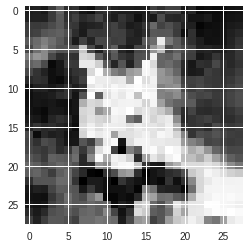

In [0]:
# prepare customized image data
from PIL import Image
import os
from urllib.request import urlretrieve
from matplotlib.pyplot import imshow

%matplotlib inline

basePath = "data"
def maybe_download(url, imageName):
  try:
    if not os.path.exists(imageName):
      urlretrieve(url, imageName)
      im = Image.open(imageName)
      im = im.resize((28,28)).convert('L')
      im.save(imageName, "JPEG")
    else:
      print("%s already exists" % imageName)
  except:
    pass

def prepare_data():
  maybe_download("https://media.newyorker.com/photos/5b48dfe812d15d2c9b41dbc7/master/w_649,c_limit/Rudell-RainbowBridge.jpg",os.path.join(basePath, "cat","1.jpg"))
  maybe_download("http://www.pawschicago.org/fileadmin/user_upload/spay-young-pets.jpg",os.path.join(basePath, "cat","2.jpg"))
  maybe_download("https://previews.123rf.com/images/nehru/nehru1505/nehru150501675/40068586-american-staffordshire-terrier-female-dog-image.jpg", os.path.join(basePath, "dog","1.jpg"))
  maybe_download("https://previews.123rf.com/images/nehru/nehru1505/nehru150500704/39774720-american-staffordshire-terrier-female-dog-image.jpg",os.path.join(basePath, "dog","2.jpg"))

def display_im(imageName):
  im = Image.open(imageName)
  imshow(im)  


#!rm -Rf data
!ls -al data
!mkdir -p data/cat
!mkdir -p data/dog
prepare_data()
#!apt install -y tree
!tree data

display_im('data/cat/1.jpg')
  


In [0]:
#loading the original dataset from mnist
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
 
mnist=input_data.read_data_sets(
    "/data/machine_learning/mnist/",
    one_hot=False
)

print(mnist.train.labels.shape)
print(type(mnist.train.labels))

Extracting /data/machine_learning/mnist/train-images-idx3-ubyte.gz
Extracting /data/machine_learning/mnist/train-labels-idx1-ubyte.gz
Extracting /data/machine_learning/mnist/t10k-images-idx3-ubyte.gz
Extracting /data/machine_learning/mnist/t10k-labels-idx1-ubyte.gz
(55000,)
<class 'numpy.ndarray'>


In [0]:
#定义网络结构
def neural_net(x_dict, params):
  imData = x_dict['images']
  layer_0 = tf.reshape(imData, [-1, 28*28])
  layer_1 = tf.layers.dense(layer_0, params['n_hidden_1']) #全连接层
  layer_2 = tf.layers.dense(layer_1, params['n_hidden_2']) #全连接层
  
  return tf.layers.dense(layer_2, params['num_classes']) #全连接层，输出层

refer to: https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec

Depending on the value of mode, different arguments are required for EstimatorSpec

    ModeKeys.TRAIN:   EstimatorSpec(mode, loss, train_op)
    ModeKeys.EVAL:    EstimatorSpec(mode, loss)
    ModeKeys.PREDICT: EstimatorSpec(mode, predictions)
    

In [0]:
def model_fn(features, labels, mode, params):
    logits = neural_net(features, params) #输出
    print(logits.shape)
    
    # EstimatorSpec.predictions
    pred_classes = tf.argmax(logits, axis=1) #预测
    
    # 区分预测模式
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode,
            predictions=pred_classes
        )
   
    # EstimatorSpec.loss 定义损失和优化函数
    loss_op=tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits,
            labels=tf.cast(labels, dtype=tf.int32)
        )
    )
    # EstimatorSpec.train_op
    train_op = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate']).minimize(
        loss_op,
        global_step=tf.train.get_global_step()
    ) 
    # EstimatorSpec.eval_metric_ops 精度
    acc_op = tf.metrics.accuracy(
        labels=labels,
        predictions=pred_classes
    )

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op}
    )

Based on https://github.com/tensorflow/models/blob/master/samples/core/get_started/custom_estimator.py

params could be passed as a dict to the model_fn


numpy_input_fn is defined: https://github.com/tensorflow/estimator/blob/master/tensorflow_estimator/python/estimator/inputs/numpy_io.py

also: tf.data Dataset based input_fn: https://medium.com/tensorflow/multi-gpu-training-with-estimators-tf-keras-and-tf-data-ba584c3134db

In [91]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
print(type(train_images))
print(train_images.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)


In [0]:
#自定义 input_fn
# based on https://github.com/tensorflow/estimator/blob/master/tensorflow_estimator/python/estimator/inputs/numpy_io.py
def udf_input_fn(
    x, y=None, 
    batch_size=1, 
    num_epochs=1, 
    shuffle=None, 
    queue_capacity=4, 
    num_threads=1):
  
  def input_fn():
    
    features, target = [], np.zeros(len(x["images"]),dtype=np.int32)
    for i in range(x["images"].shape[0]):
    #for i in range(1):
      im = Image.open(x["images"][i])
      # originally it should be divided by 255.0 only
      # due to some network issues, it is further divided
      im = np.asarray(im, dtype = np.float32) / 255.0 / 4.0
      features.append(im)
      if x["images"][i].find('cat') >=0:
        target[i] = 0
      else:
        target[i] = 1
    
    features = np.array(features)
    target = np.array(target) 
    
    features = {"images":tf.convert_to_tensor(features, dtype=tf.float32)}
    # no need to convert it to one hot for sparse_softmax_cross_entropy_with_logits
    target = tf.convert_to_tensor(target, dtype=tf.int32)
    
    return features, target
      
  return input_fn

In [0]:
#参数设置
num_steps=1000 #迭代次数
batch_size=128 #批处理大小
display_step=100 #输出间隔

model = tf.estimator.Estimator(
    model_fn,
    params ={
      'n_hidden_1': 256,    #第一个隐藏层神经元
      'n_hidden_2': 256,    #第二个隐藏层神经元
      'num_classes': 10,    #标签类别
      'learning_rate': 0.1, #学习率
    }
)

# suppose to change the control here
usingMnistData = False
if usingMnistData:
  train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={'images':mnist.train.images}, # numpy.ndarray
      y=mnist.train.labels,            # numpy.ndarray
      batch_size=batch_size,
      num_epochs=None,
      shuffle=True
  )
else:
  # plugin the udf input fn
  train_input_fn = udf_input_fn(
    x={
      "images":np.array([
        'data/cat/1.jpg',
        'data/cat/2.jpg',
        'data/dog/1.jpg',
        'data/dog/2.jpg'
      ])
    }, # numpy.ndarray
    #y=xx,            # ignoring y, since y is generated from x
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True
  )


model.train(
    train_input_fn,
    steps=num_steps
)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images':mnist.test.images},
    y=mnist.test.labels,
    batch_size=batch_size,
    shuffle=False
)

e = model.evaluate(eval_input_fn)
print("测试精度：",e['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpax6_yeog', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f00e24394a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
(4, 10)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow: